

# Siren Exploration

In [1]:
# Imports
import os
import random
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm

from utils.Siren_LIIF_style_utils import(
    get_mgrid_2d,
    SingleImagePatchDataset,
    ConditionedSiren,
)

# Single image with Neighborhood Conditionning (LIIF style)

This section sets up the dataset and model for training on a single image using LIIF-style conditioning. The model is given both the pixel coordinates and a patch of neighboring pixel values as input. The goal is to predict the RGB value of the target pixel.

In [2]:
# Training setup
dataset = SingleImagePatchDataset("data/archive/DIV2K_train_HR/0001.png")
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)
model = ConditionedSiren() #.cuda()
sample = dataset[0]
print("Sample patch shape:", sample['patch'].shape)  # Should be torch.Size([24])
print("Model first layer weight shape:", model.net[0].linear.weight.shape)  # Should be torch.Size([256, 26])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Sample patch shape: torch.Size([24])
Model first layer weight shape: torch.Size([256, 26])


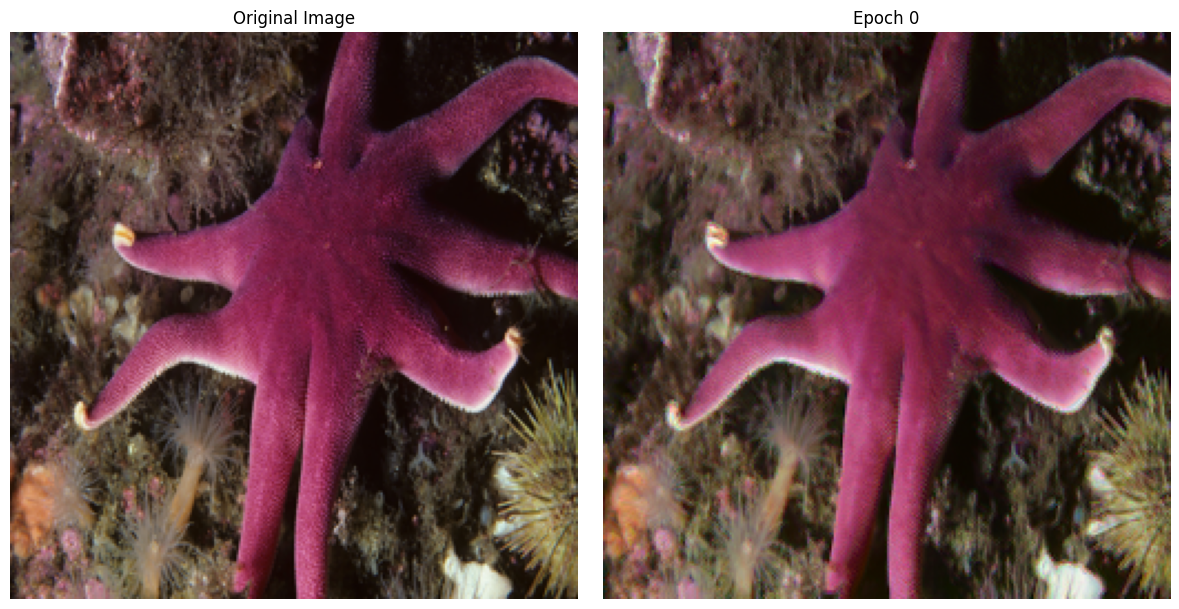

Epoch 1, Loss: 0.0093
Epoch 2, Loss: 0.0063
Epoch 2, Loss: 0.0063


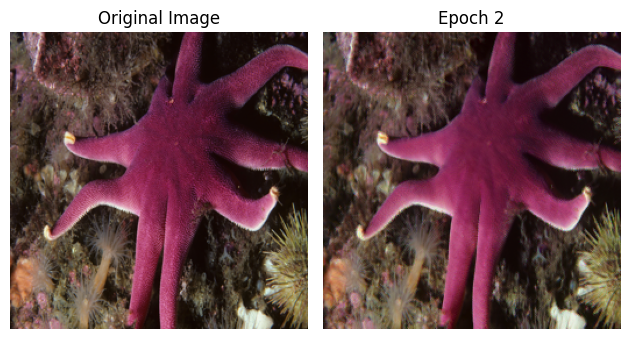

Epoch 3, Loss: 0.0055
Epoch 4, Loss: 0.0043
Epoch 4, Loss: 0.0043


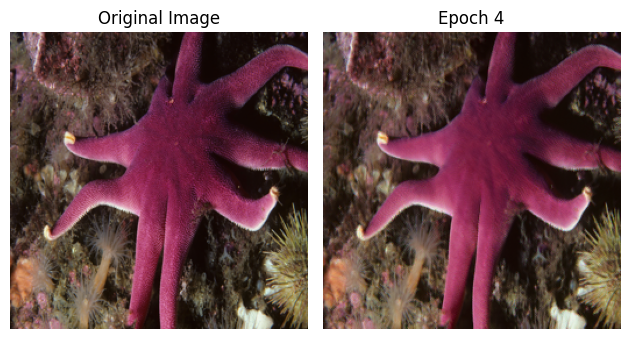

Epoch 5, Loss: 0.0042
Epoch 6, Loss: 0.0040
Epoch 6, Loss: 0.0040


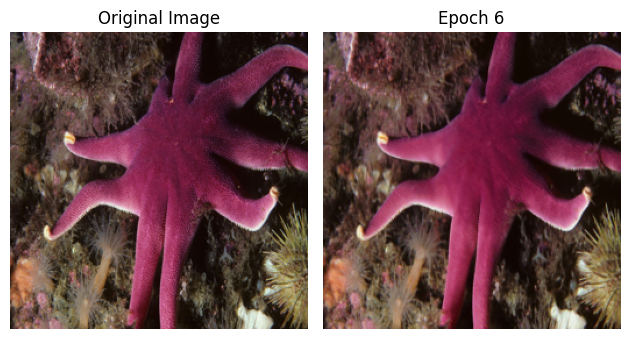

Epoch 7, Loss: 0.0041
Epoch 8, Loss: 0.0037
Epoch 8, Loss: 0.0037


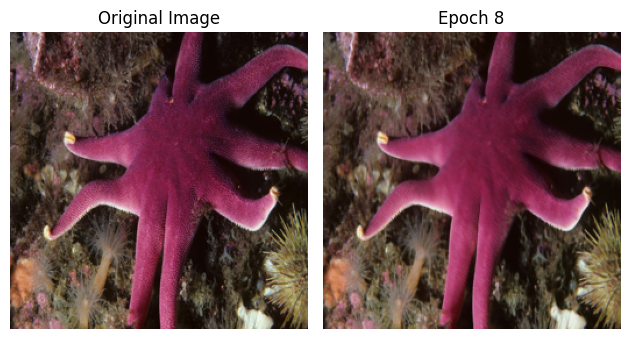

Epoch 9, Loss: 0.0036
Epoch 10, Loss: 0.0039
Epoch 10, Loss: 0.0039


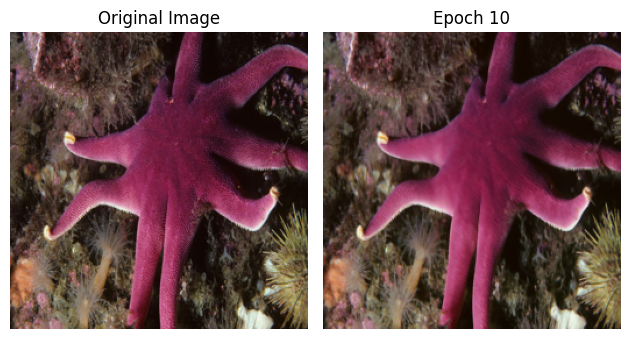

Epoch 11, Loss: 0.0032
Epoch 12, Loss: 0.0032
Epoch 12, Loss: 0.0032


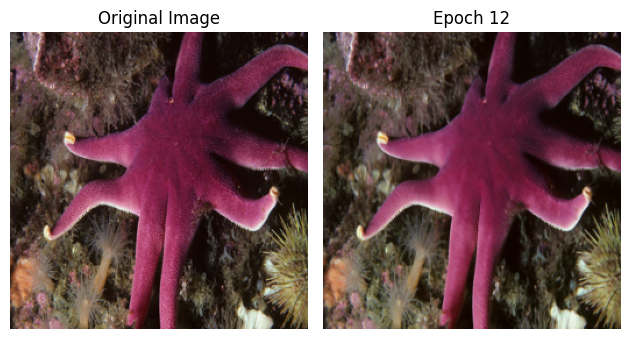

Epoch 13, Loss: 0.0038
Epoch 14, Loss: 0.0033
Epoch 14, Loss: 0.0033


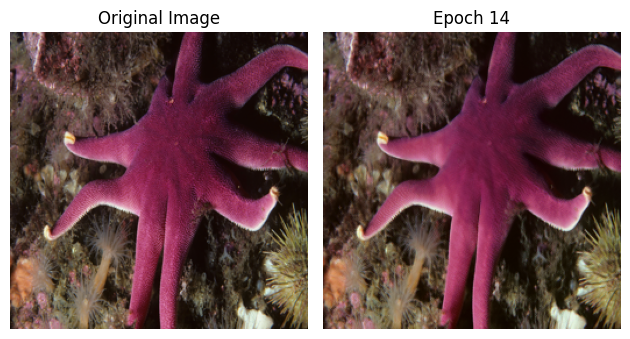

Epoch 15, Loss: 0.0032
Epoch 16, Loss: 0.0027
Epoch 16, Loss: 0.0027


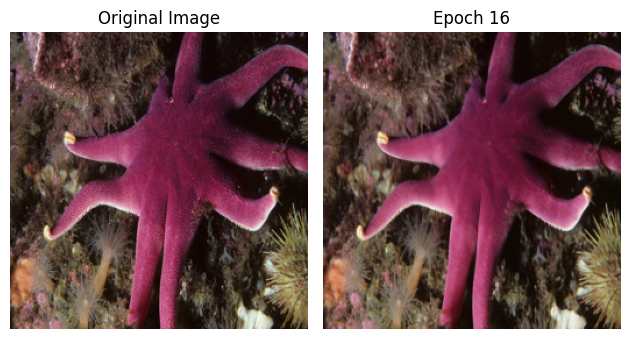

Epoch 17, Loss: 0.0031
Epoch 18, Loss: 0.0033
Epoch 18, Loss: 0.0033


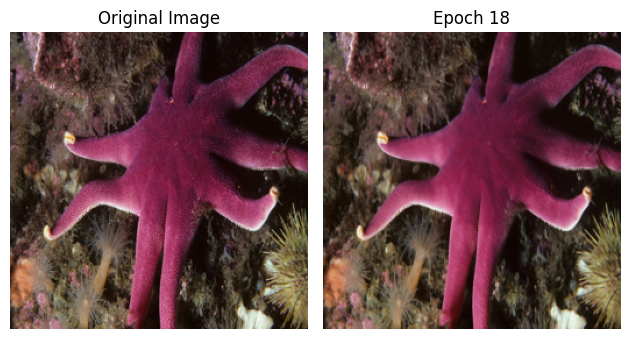

Epoch 19, Loss: 0.0031
Epoch 20, Loss: 0.0029
Epoch 20, Loss: 0.0029


<Figure size 640x480 with 0 Axes>

In [3]:
visualize_every = 2  # Show image every 2 epochs
pad = dataset.pad_size

# Get original image for comparison
original_img = (dataset.img_tensor.permute(1, 2, 0).cpu().numpy() + 1) / 2

# Create figure
plt.figure(figsize=(12, 6))

# Initialize a list to track the loss values
losses = []

# Training loop with loss tracking
for epoch in range(20):
    for batch in dataloader:
        coords = batch['coord']  
        patches = batch['patch'] 
        targets = batch['target']

        preds = model(coords, patches)
        loss = F.mse_loss(preds, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Track the loss for each epoch
    losses.append(loss.item())

    if epoch % visualize_every == 0:
        model.eval()
        with torch.no_grad():
            # Create full grid inference
            all_coords = dataset.coords 

            # Get all patches at once using unfold
            padded_img = F.pad(dataset.img_tensor.unsqueeze(0), (pad,) * 4, mode='reflect')[0]  # 1xCxHxW
            patches = padded_img.unfold(1, 3, 1).unfold(2, 3, 1)  # CxHxWx3x3
            patches = patches.permute(1, 2, 0, 3, 4)  # HxWxCx3x3
            patches = patches.reshape(-1, 3, 9)  # (H*W)x3x9
            # Remove center pixels (index 4 in each channel's 3x3 patch)
            patches = torch.cat([patches[:, :, :4], patches[:, :, 5:]], dim=2)  # (H*W)x3x8
            patches = patches.reshape(-1, 24)  # (H*W)x24

            # Predict full image
            preds = model(all_coords, patches)  # .cuda())
            reconstructed = preds.cpu().numpy().reshape(dataset.img_tensor.shape[1],
                                                        dataset.img_tensor.shape[2], 3)

            # Denormalize
            reconstructed = (reconstructed + 1) / 2

            # Plot
            plt.subplot(1, 2, 1)
            plt.imshow(original_img)
            plt.title("Original Image")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(reconstructed.clip(0, 1))
            plt.title(f"Epoch {epoch}")
            plt.axis('off')

            plt.tight_layout()
            plt.pause(0.01)
            plt.draw()

        model.train()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

## Loss Tracking and Visualization
During training, the loss is tracked for each epoch to monitor the model's performance. The loss curve is plotted after training to visualize the convergence of the model.

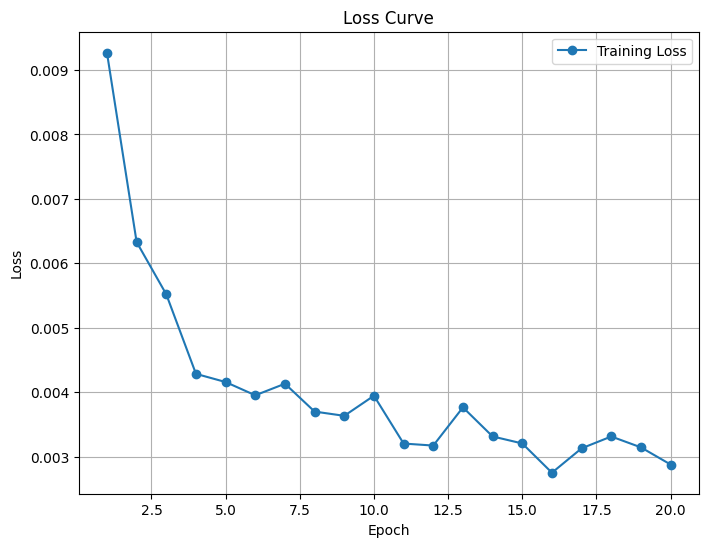

In [4]:
# Plot the loss curve after training
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(losses) + 1), losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid()
plt.show()